In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point

# for qqplot
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
# for adding some text in plot
from matplotlib.offsetbox import AnchoredText

# for train test split, for cross validation, and for measure
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_error as MSE
# for data standard scaler
from sklearn.preprocessing import StandardScaler

# for Multiple linear regression
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

# for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

In [2]:
import libpysal
import mgwr
import esda
from mgwr.gwr import GWR, MGWR
from matplotlib import colors
import spreg

# MSOA shapefile data

In [3]:
msoa_ew_shp_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/shapefile/England/MSOA_EngWal_Dec_2011_Generalised_ClippedEW_0/Middle_Layer_Super_Output_Areas_December_2011_Generalised_Clipped_Boundaries_in_England_and_Wales.shp"
msoa_ew_shp = gpd.read_file(msoa_ew_shp_url)

In [4]:
msoa_england_shp = msoa_ew_shp[msoa_ew_shp['msoa11cd'].str.startswith("E")]

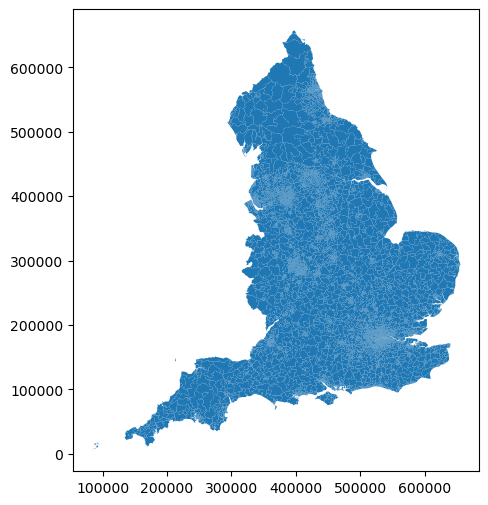

In [5]:
f, axes = plt.subplots(1, 1, figsize=(6, 6))
msoa_england_shp.plot(ax=axes)
plt.show()

# Data processing and wrangling

## Y variable

In [93]:
pre_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/Variable_y/MSOA_modelledestimates_prevalence.csv"
msoa_methods_pre_data = pd.read_csv(pre_url)

In [96]:
msoa_methods_pre_data.columns = ['Unnamed: 0', 'MSOA11CD', 'group_code', 'prevalence', 'Name',
                                 'condition', 'description']

msoa_methods_pre_dm = msoa_methods_pre_data[msoa_methods_pre_data["group_code"] == 'DM'].copy()
msoa_methods_pre_dm['prevalence'] = msoa_methods_pre_dm.prevalence

msoa_methods_pre_dm = msoa_methods_pre_dm[['MSOA11CD', 'prevalence']]

## X variables

### 1. Sex and Age

In [11]:
msoa_sexage_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/Variable_x/sex_age_estimate/sapemsoasyoatablefinal.xlsx"
msoa_sexage = pd.read_excel(msoa_sexage_url, sheet_name=5)

In [12]:
msoa_sexage_copy = msoa_sexage.copy()
msoa_sexage_copy = msoa_sexage_copy.iloc[2:]
msoa_sexage_copy.reset_index(inplace=True, drop=True)
msoa_sexage_copy.columns = msoa_sexage_copy.iloc[0]
msoa_sexage_copy = msoa_sexage_copy.iloc[1:]
msoa_sexage_copy = msoa_sexage_copy.drop(columns = ['LAD 2021 Code', 'LAD 2021 Name', 'MSOA 2021 Name'])

for col in msoa_sexage_copy.columns[1:]:
    msoa_sexage_copy[col] = pd.to_numeric(msoa_sexage_copy[col], errors='coerce')
    
msoa_sexage_copy = msoa_sexage_copy.copy()

msoa_sexage_copy.columns.values[0] = 'Areacode'

msoa_sexage_copy

,Areacode,Total,F0,F1,F2,F3,F4,F5,F6,F7,...,M81,M82,M83,M84,M85,M86,M87,M88,M89,M90
1,E02002483,10323,58,49,62,49,47,65,61,53,...,21,18,22,12,22,14,17,14,15,28
2,E02002484,10460,57,67,65,73,63,71,66,70,...,16,23,19,9,11,10,10,12,6,28
3,E02002485,8040,41,36,57,52,52,65,61,52,...,16,13,10,6,10,8,4,6,3,12
4,E02002489,7312,28,38,31,30,26,43,32,39,...,12,7,14,9,7,7,4,3,4,5
5,E02002490,5824,27,35,32,37,36,40,47,37,...,3,7,10,7,6,5,5,5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7260,W02000286,6795,30,29,33,35,36,40,40,48,...,19,15,18,9,15,11,6,6,5,15
7261,W02000287,8299,35,43,46,48,53,58,49,43,...,16,19,18,19,6,7,8,3,6,15
7262,W02000288,8041,29,31,36,37,26,43,45,39,...,13,17,14,22,22,18,13,6,6,17
7263,W02000289,8688,36,36,48,54,37,48,41,43,...,13,17,15,13,8,10,18,13,11,21


In [17]:
# calculate female population
female_all_col = msoa_sexage_copy.filter(like='F').columns
msoa_sexage_copy['Total_female'] = msoa_sexage_copy[female_all_col].sum(axis=1)

# calculate male population
male_all_col = msoa_sexage_copy.filter(like='M').columns
msoa_sexage_copy['Total_male'] = msoa_sexage_copy[male_all_col].sum(axis=1)

# calculate total population
msoa_sexage_copy['Total_popu'] = msoa_sexage_copy['Total_female'] + msoa_sexage_copy['Total_male']
# lsoa_sexage_copy['femalerate'] = lsoa_sexage_copy['Total_Female'] / lsoa_sexage_copy['Total']


# calculate 17-25 population
female_17to25_col = msoa_sexage_copy.filter(regex='^F(1[7-9]|2[0-5])$').columns
msoa_sexage_copy['Total_female_17to25'] = msoa_sexage_copy[female_17to25_col].sum(axis=1)

male_17to25_col = msoa_sexage_copy.filter(regex='^M(1[7-9]|2[0-5])$').columns
msoa_sexage_copy['Total_male_17to25'] = msoa_sexage_copy[male_17to25_col].sum(axis=1)

msoa_sexage_copy['17to25popu'] = msoa_sexage_copy['Total_female_17to25'] + msoa_sexage_copy['Total_male_17to25']


# calculate 26-44 population
female_26to44_col = msoa_sexage_copy.filter(regex='^F(2[6-9]|3[0-9]|4[0-4])$').columns
msoa_sexage_copy['Total_female_26to44'] = msoa_sexage_copy[female_26to44_col].sum(axis=1)

male_26to44_col = msoa_sexage_copy.filter(regex='^M(2[6-9]|3[0-9]|4[0-4])$').columns
msoa_sexage_copy['Total_male_26to44'] = msoa_sexage_copy[male_26to44_col].sum(axis=1)

msoa_sexage_copy['26to44popu'] = msoa_sexage_copy['Total_female_26to44'] + msoa_sexage_copy['Total_male_26to44']


# calculate 45-64 population
female_45to64_col = msoa_sexage_copy.filter(regex='^F(4[5-9]|5[0-9]|6[0-4])$').columns
msoa_sexage_copy['Total_female_45to64'] = msoa_sexage_copy[female_45to64_col].sum(axis=1)

male_45to64_col = msoa_sexage_copy.filter(regex='^M(4[5-9]|5[0-9]|6[0-4])$').columns
msoa_sexage_copy['Total_male_45to64'] = msoa_sexage_copy[male_45to64_col].sum(axis=1)

msoa_sexage_copy['45to64popu'] = msoa_sexage_copy['Total_female_45to64'] + msoa_sexage_copy['Total_male_45to64']


# calcualte 65+age popoulation
female_65_col = msoa_sexage_copy.filter(regex='^F(6[5-9]|[7-9][0-9]|100)$').columns
msoa_sexage_copy['Total_female_65'] = msoa_sexage_copy[female_65_col].sum(axis=1)

male_65_col = msoa_sexage_copy.filter(regex='^M(6[5-9]|[7-9][0-9]|100)$').columns
msoa_sexage_copy['Total_male_65'] = msoa_sexage_copy[male_65_col].sum(axis=1)

msoa_sexage_copy['65popu'] = msoa_sexage_copy['Total_female_65'] + msoa_sexage_copy['Total_male_65']

In [18]:
Sexage = msoa_sexage_copy[['Areacode', 'Total', 'Total_female',
                           '17to25popu', '26to44popu', '45to64popu', '65popu']]
Sexage.columns = ['MSOA21CD', 'Total', 'Total_female', 'young', 'adult', 'madult', 'old']
Sexage

,MSOA21CD,Total,Total_female,young,adult,madult,old
1,E02002483,10323,5352,1006,2610,2705,1884
2,E02002484,10460,5319,1066,2424,2736,1834
3,E02002485,8040,4239,834,1872,2060,1379
4,E02002489,7312,3694,1040,1654,1828,1277
5,E02002490,5824,2948,569,1431,1577,979
...,...,...,...,...,...,...,...
7260,W02000286,6795,3473,679,1724,1772,1264
7261,W02000287,8299,4166,786,2050,2229,1612
7262,W02000288,8041,4017,794,2023,2147,1599
7263,W02000289,8688,4400,782,2120,2330,1805


### 2. Ethic group

In [25]:
Ethicdf_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/Variable_x/ethnic_group/census2021-ts021_ethicgroup/census2021-ts021-msoa.csv"
Ethicdf = pd.read_csv(Ethicdf_url)

In [26]:
Ethicdf_col = ['geography code', 'Ethnic group: Total: All usual residents',
            'Ethnic group: Asian, Asian British or Asian Welsh',
            'Ethnic group: Black, Black British, Black Welsh, Caribbean or African',
            'Ethnic group: Mixed or Multiple ethnic groups',
            'Ethnic group: White',
            'Ethnic group: Other ethnic group']
Ethicdf = Ethicdf[Ethicdf_col]
Ethicdf.columns = ['MSOA21CD', 'ethicall', 'asian', 'black', 'mixed', 'white', 'other']

In [27]:
Ethicdf

,MSOA21CD,ethicall,asian,black,mixed,white,other
0,E02000001,8584,1445,232,470,5955,482
1,E02000002,8282,1843,1737,408,4043,251
2,E02000003,11538,4032,1800,484,4692,530
3,E02000004,6642,1053,946,246,4175,222
4,E02000005,11081,3333,1957,477,4917,397
...,...,...,...,...,...,...,...
7259,W02000424,6682,74,4,69,6511,24
7260,W02000425,8347,191,65,189,7867,35
7261,W02000426,9897,177,50,81,9552,37
7262,W02000427,11145,61,44,82,10942,16


### 3. 2021MSOA code to 2011MSOA code

In [36]:
Census21 = [Sexage, Ethicdf]

In [37]:
Merge21 = Census21[0]
for df in Census21[1:]:
    Merge21 = Merge21.merge(df, on='MSOA21CD', how='left')

In [38]:
# Import the assistance dataframe for 2021 and 2011 MSOA code mapping
MSOAMAP_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/21to11code/MSOA_(2011)_to_MSOA_(2021)_to_Local_Authority_District_(2022)_Lookup_for_England_and_Wales_-1574171694243467521.csv"
MSOAMAP = pd.read_csv(MSOAMAP_url)
MSOAMAP = MSOAMAP[['MSOA11CD', 'CHGIND', 'MSOA21CD']]
MSOAMAP

,MSOA11CD,CHGIND,MSOA21CD
0,E02000001,U,E02000001
1,E02000002,U,E02000002
2,E02000003,U,E02000003
3,E02000004,U,E02000004
4,E02000005,U,E02000005
...,...,...,...
7282,W02000086,M,W02000426
7283,W02000203,M,W02000427
7284,W02000209,M,W02000427
7285,W02000187,M,W02000428


In [39]:
Merge = pd.merge(MSOAMAP, Merge21, how='left', left_on='MSOA21CD', right_on='MSOA21CD')

MergeU = Merge[Merge['CHGIND'] == 'U']
MergeS = Merge[Merge['CHGIND'] == 'S']
MergeM = Merge[Merge['CHGIND'] == 'M']
MergeX = Merge[Merge['CHGIND'] == 'X']

In [40]:
code11_col = ['MSOA11CD'] + list(Merge.columns)[3:]
num_col = list(Merge.columns)[3:]

In [41]:
Merge11U = MergeU[code11_col]
Merge11U

,MSOA11CD,Total,Total_female,young,adult,madult,old,ethicall,asian,black,mixed,white,other
0,E02000001,10847,4786,1917,4684,2395,1300,8584,1445,232,470,5955,482
1,E02000002,8384,4442,903,2281,1791,1011,8282,1843,1737,408,4043,251
2,E02000003,11803,5965,1342,3562,2539,1395,11538,4032,1800,484,4692,530
3,E02000004,6870,3483,738,1836,1652,1119,6642,1053,946,246,4175,222
4,E02000005,11046,5712,1208,3272,2431,926,11081,3333,1957,477,4917,397
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7274,W02000418,12385,6288,844,2331,3617,3443,12255,57,20,101,12047,30
7275,W02000419,11483,5996,955,2551,2998,2625,11361,157,32,105,11030,37
7276,W02000421,11204,5667,870,1909,3464,3156,11484,133,77,99,11145,30
7277,W02000422,7604,3489,1182,3985,1185,407,7389,796,401,332,5406,454


In [42]:
Merge11S = MergeS[code11_col].groupby('MSOA11CD').sum()
Merge11S = Merge11S.reset_index()
Merge11S

,MSOA11CD,Total,Total_female,young,adult,madult,old,ethicall,asian,black,mixed,white,other
0,E02000053,20704,10403,2632,8789,3889,1098,19280,6462,2236,1073,7297,2212
1,E02000109,19416,10081,4964,6882,3218,1245,16338,6303,2647,732,5373,1283
2,E02000220,15066,7621,1554,7013,2766,1066,14535,2644,2924,1134,7073,760
3,E02000257,15051,7644,1381,5657,3431,1939,14775,3342,748,904,8176,1605
4,E02000274,15652,7553,2215,4452,3894,1527,15636,11405,1285,291,874,1781
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,E02006870,14887,7677,1246,3618,3972,3253,14500,128,48,147,14088,89
72,E02006901,16065,8071,2561,4507,2888,1143,15912,11901,783,393,1891,944
73,E02006911,15356,7775,2446,3358,3817,2708,15206,8246,410,523,5116,911
74,E02006929,17555,8923,2141,8710,2676,673,16625,2941,2844,1198,8911,731


In [44]:
Merge11M = MergeM[code11_col].copy()
Merge11M[num_col] = Merge11M[num_col].apply(lambda x: x / 2)
Merge11M.head()

,MSOA11CD,Total,Total_female,young,adult,madult,old,ethicall,asian,black,mixed,white,other
6416,E02002971,5429.0,2726.0,530.5,1409.0,1400.5,1013.0,5490.0,225.0,92.5,99.5,5026.5,46.5
6417,E02002972,5429.0,2726.0,530.5,1409.0,1400.5,1013.0,5490.0,225.0,92.5,99.5,5026.5,46.5
6424,E02006183,6153.0,3164.0,477.0,1327.0,1685.5,1568.0,6088.0,244.0,73.0,151.5,5584.5,35.0
6425,E02006184,6153.0,3164.0,477.0,1327.0,1685.5,1568.0,6088.0,244.0,73.0,151.5,5584.5,35.0
6445,E02001599,5788.0,2982.0,493.0,1228.5,1672.0,1376.5,5762.5,238.5,40.5,65.5,5369.0,49.0


In [45]:
MergeX_copy = MergeX.copy()
MergeX_copy['MSOA21CD_count'] = MergeX_copy.groupby('MSOA21CD')['MSOA21CD'].transform('count')
for col in num_col:
    MergeX_copy[col] = MergeX_copy[col] / MergeX_copy['MSOA21CD_count']
    
# 删除临时列
MergeX_copy.drop(columns=['MSOA21CD_count'], inplace=True)

Merge11X = MergeX_copy[code11_col].groupby('MSOA11CD').sum()
Merge11X = Merge11X.reset_index()

In [46]:
Merge11X

,MSOA11CD,Total,Total_female,young,adult,madult,old,ethicall,asian,black,mixed,white,other
0,E02000750,19128.0,9705.0,2380.0,9311.0,3078.0,532.0,18336.0,4425.0,4195.0,1276.0,7677.0,763.0
1,E02001705,7926.0,4142.5,570.0,1490.0,2261.5,2329.5,7824.0,53.5,26.0,67.5,7653.0,24.0
2,E02004879,11245.5,5697.5,919.5,2350.0,3406.5,2525.0,11336.0,253.0,179.0,206.5,10628.0,69.5
3,E02004938,3059.5,1511.0,296.0,614.0,954.0,497.5,3133.5,216.0,73.5,140.0,2649.0,55.0
4,E02004947,3178.5,1607.5,269.5,802.0,949.5,566.0,3219.0,175.0,144.0,83.5,2781.0,35.5
5,E02004993,8634.5,4442.0,982.0,1972.0,2368.0,1607.5,8621.5,575.0,343.5,379.0,7160.0,164.0
6,E02005732,7926.0,4142.5,570.0,1490.0,2261.5,2329.5,7824.0,53.5,26.0,67.5,7653.0,24.0


In [47]:
# combine all above data partition
# Now 7201 MSOA for 2011 code (England and Walse)
Merge11 = pd.concat([Merge11U, Merge11S, Merge11M, Merge11X], axis=0, ignore_index=True)
Merge11

,MSOA11CD,Total,Total_female,young,adult,madult,old,ethicall,asian,black,mixed,white,other
0,E02000001,10847.0,4786.0,1917.0,4684.0,2395.0,1300.0,8584.0,1445.0,232.0,470.0,5955.0,482.0
1,E02000002,8384.0,4442.0,903.0,2281.0,1791.0,1011.0,8282.0,1843.0,1737.0,408.0,4043.0,251.0
2,E02000003,11803.0,5965.0,1342.0,3562.0,2539.0,1395.0,11538.0,4032.0,1800.0,484.0,4692.0,530.0
3,E02000004,6870.0,3483.0,738.0,1836.0,1652.0,1119.0,6642.0,1053.0,946.0,246.0,4175.0,222.0
4,E02000005,11046.0,5712.0,1208.0,3272.0,2431.0,926.0,11081.0,3333.0,1957.0,477.0,4917.0,397.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7196,E02004879,11245.5,5697.5,919.5,2350.0,3406.5,2525.0,11336.0,253.0,179.0,206.5,10628.0,69.5
7197,E02004938,3059.5,1511.0,296.0,614.0,954.0,497.5,3133.5,216.0,73.5,140.0,2649.0,55.0
7198,E02004947,3178.5,1607.5,269.5,802.0,949.5,566.0,3219.0,175.0,144.0,83.5,2781.0,35.5
7199,E02004993,8634.5,4442.0,982.0,1972.0,2368.0,1607.5,8621.5,575.0,343.5,379.0,7160.0,164.0


### 4. Calculate rate and density (Sex, Age, Ethic, Population density)

In [48]:
Merge11.columns

Index(['MSOA11CD', 'Total', 'Total_female', 'young', 'adult', 'madult', 'old',
       'ethicall', 'asian', 'black', 'mixed', 'white', 'other'],
      dtype='object')

In [79]:
Merge11data = Merge11.copy()

In [80]:
Merge11data['asianr'] = Merge11data.asian / Merge11data.ethicall
Merge11data['blackr'] = Merge11data.black / Merge11data.ethicall
Merge11data['mixedr'] = Merge11data.mixed / Merge11data.ethicall
Merge11data['whiter'] = Merge11data.white / Merge11data.ethicall
Merge11data['otherr'] = Merge11data.other / Merge11data.ethicall

In [81]:
Merge11data['femaler'] = Merge11data.Total_female / Merge11data.Total
Merge11data['oldr'] = Merge11data.old / Merge11data.Total
Merge11data['youngr'] = Merge11data.young / Merge11data.Total
Merge11data['adultr'] = Merge11data.adult / Merge11data.Total
Merge11data['madultr'] = Merge11data.madult / Merge11data.Total

In [82]:
# Population density (per hectare)
Areadf = msoa_england_shp[['msoa11cd', 'st_areasha']].copy()
Areadf.columns = ['MSOA11CD', 'area']

# convert to hectare
Areadf['area'] = Areadf['area'] / 10000

# Merge with area
Merge11data = pd.merge(Merge11data, Areadf, how='left', left_on='MSOA11CD', right_on='MSOA11CD')

# calculate density
Merge11data['popudensity'] = Merge11data.Total / Merge11data.area

In [83]:
Merge11data

,MSOA11CD,Total,Total_female,young,adult,madult,old,ethicall,asian,black,...,mixedr,whiter,otherr,femaler,oldr,youngr,adultr,madultr,area,popudensity
0,E02000001,10847.0,4786.0,1917.0,4684.0,2395.0,1300.0,8584.0,1445.0,232.0,...,0.054753,0.693733,0.056151,0.441228,0.119849,0.176731,0.431824,0.220798,290.539931,37.333939
1,E02000002,8384.0,4442.0,903.0,2281.0,1791.0,1011.0,8282.0,1843.0,1737.0,...,0.049263,0.488167,0.030307,0.529819,0.120587,0.107705,0.272066,0.213621,216.563377,38.713840
2,E02000003,11803.0,5965.0,1342.0,3562.0,2539.0,1395.0,11538.0,4032.0,1800.0,...,0.041948,0.406656,0.045935,0.505380,0.118190,0.113700,0.301788,0.215115,214.356500,55.062478
3,E02000004,6870.0,3483.0,738.0,1836.0,1652.0,1119.0,6642.0,1053.0,946.0,...,0.037037,0.628576,0.033424,0.506987,0.162882,0.107424,0.267249,0.240466,249.021545,27.587974
4,E02000005,11046.0,5712.0,1208.0,3272.0,2431.0,926.0,11081.0,3333.0,1957.0,...,0.043047,0.443733,0.035827,0.517110,0.083831,0.109361,0.296216,0.220080,118.617993,93.122466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7196,E02004879,11245.5,5697.5,919.5,2350.0,3406.5,2525.0,11336.0,253.0,179.0,...,0.018216,0.937544,0.006131,0.506647,0.224534,0.081766,0.208972,0.302921,9834.754900,1.143445
7197,E02004938,3059.5,1511.0,296.0,614.0,954.0,497.5,3133.5,216.0,73.5,...,0.044678,0.845381,0.017552,0.493872,0.162608,0.096748,0.200686,0.311816,1120.990298,2.729283
7198,E02004947,3178.5,1607.5,269.5,802.0,949.5,566.0,3219.0,175.0,144.0,...,0.025940,0.863933,0.011028,0.505742,0.178071,0.084788,0.252320,0.298726,127.787818,24.873263
7199,E02004993,8634.5,4442.0,982.0,1972.0,2368.0,1607.5,8621.5,575.0,343.5,...,0.043960,0.830482,0.019022,0.514448,0.186172,0.113730,0.228386,0.274249,1131.621579,7.630201


In [86]:
Merge11data_col = ['MSOA11CD'] + ['asianr', 'blackr', 'mixedr', 'whiter', 'otherr'] + ['femaler', 'popudensity',                                                       
                   'youngr', 'adultr', 'madultr', 'oldr']

In [89]:
Census_data = Merge11data[Merge11data_col]

# only with england 6791 MSOA
Census_data = Census_data[Census_data['MSOA11CD'].str.startswith("E")]

In [90]:
Census_data.dropna()

,MSOA11CD,asianr,blackr,mixedr,whiter,otherr,femaler,popudensity,youngr,adultr,madultr,oldr
0,E02000001,0.168336,0.027027,0.054753,0.693733,0.056151,0.441228,37.333939,0.176731,0.431824,0.220798,0.119849
1,E02000002,0.222531,0.209732,0.049263,0.488167,0.030307,0.529819,38.713840,0.107705,0.272066,0.213621,0.120587
2,E02000003,0.349454,0.156006,0.041948,0.406656,0.045935,0.505380,55.062478,0.113700,0.301788,0.215115,0.118190
3,E02000004,0.158537,0.142427,0.037037,0.628576,0.033424,0.506987,27.587974,0.107424,0.267249,0.240466,0.162882
4,E02000005,0.300785,0.176609,0.043047,0.443733,0.035827,0.517110,93.122466,0.109361,0.296216,0.220080,0.083831
...,...,...,...,...,...,...,...,...,...,...,...,...
7196,E02004879,0.022318,0.015790,0.018216,0.937544,0.006131,0.506647,1.143445,0.081766,0.208972,0.302921,0.224534
7197,E02004938,0.068933,0.023456,0.044678,0.845381,0.017552,0.493872,2.729283,0.096748,0.200686,0.311816,0.162608
7198,E02004947,0.054365,0.044734,0.025940,0.863933,0.011028,0.505742,24.873263,0.084788,0.252320,0.298726,0.178071
7199,E02004993,0.066694,0.039842,0.043960,0.830482,0.019022,0.514448,7.630201,0.113730,0.228386,0.274249,0.186172


### 5. Adult diet data

In [91]:
dietdata_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/Variable_x/lifestyle_care/adult_diet.csv"
dietdata = pd.read_csv(dietdata_url)
dietdata = dietdata[['MSOA_code', 'LowFV', 'HighSSB']]
dietdata.columns = ['MSOA11CD', 'LowFV', 'HighSSB']

In [92]:
dietdata

,MSOA11CD,LowFV,HighSSB
0,E02000001,8.086201,11.617112
1,E02000002,9.158512,12.923564
2,E02000003,6.636457,12.904267
3,E02000004,6.850284,12.772685
4,E02000005,7.747710,13.643012
...,...,...,...
6786,E02006930,8.052239,14.441009
6787,E02006931,8.667703,12.911827
6788,E02006932,12.416160,28.914023
6789,E02006933,9.741796,19.586924


### 6. Alcohol data (and children care data)

In [99]:
alco_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/Variable_x/lifestyle_care/alcohol_care.csv"
alcodata = pd.read_csv(alco_url)

In [101]:
alcodata.columns = ['MSOA11CD', 'Label', 'childrenemerg', 'alcohol']
alcodata = alcodata[['MSOA11CD', 'childrenemerg', 'alcohol']]

### 7. OB and COPD data

In [98]:
msoa_methods_pre_ob = msoa_methods_pre_data[msoa_methods_pre_data["group_code"] == 'OB'].copy()
msoa_methods_pre_ob['obprev'] = msoa_methods_pre_ob.prevalence

msoa_methods_pre_ob = msoa_methods_pre_ob[['MSOA11CD', 'obprev']]


msoa_methods_pre_copd = msoa_methods_pre_data[msoa_methods_pre_data["group_code"] == 'COPD'].copy()
msoa_methods_pre_copd['copdprev'] = msoa_methods_pre_copd.prevalence

msoa_methods_pre_copd = msoa_methods_pre_copd[['MSOA11CD', 'copdprev']]

### 8. IMD data

In [102]:
IMD_data_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/Variable_x/IMD/imd2019_msoa_level_data.csv"
IMD_data = pd.read_csv(IMD_data_url)

In [104]:
IMD_data = IMD_data[['MSOAC', 'IMD19 SCORE', 'MSOADECILE', 'MSOAQUINTILE']]
IMD_data.columns = ['MSOA11CD', 'Imdscore', 'Imddecile', 'Imdquintile']

## Merge all data

In [105]:
All_data = [Census_data, dietdata, alcodata, msoa_methods_pre_copd, msoa_methods_pre_ob, IMD_data,
            msoa_methods_pre_dm]

In [107]:
MergeAll = All_data[0]
for df in All_data[1:]:
    MergeAll = MergeAll.merge(df, on='MSOA11CD', how='left')

In [113]:
MergeAll
# MergeAll.to_csv("/Users/shengaric/Desktop/CASA0010 Dissertation/MSOA_data/All_msoa_data/msoa_all_data.csv", index=False)

,MSOA11CD,asianr,blackr,mixedr,whiter,otherr,femaler,popudensity,youngr,adultr,...,LowFV,HighSSB,childrenemerg,alcohol,copdprev,obprev,Imdscore,Imddecile,Imdquintile,prevalence
0,E02000001,0.168336,0.027027,0.054753,0.693733,0.056151,0.441228,37.333939,0.176731,0.431824,...,8.086201,11.617112,54.7,71.4,0.48,3.35,14.720484,7,4,2.74
1,E02000002,0.222531,0.209732,0.049263,0.488167,0.030307,0.529819,38.713840,0.107705,0.272066,...,9.158512,12.923564,63.8,110.1,1.35,12.49,34.767560,2,1,9.58
2,E02000003,0.349454,0.156006,0.041948,0.406656,0.045935,0.505380,55.062478,0.113700,0.301788,...,6.636457,12.904267,68.0,81.8,1.06,12.29,25.149726,4,2,9.61
3,E02000004,0.158537,0.142427,0.037037,0.628576,0.033424,0.506987,27.587974,0.107424,0.267249,...,6.850284,12.772685,60.5,85.9,1.40,14.72,23.560044,4,2,8.98
4,E02000005,0.300785,0.176609,0.043047,0.443733,0.035827,0.517110,93.122466,0.109361,0.296216,...,7.747710,13.643012,74.7,98.2,1.43,13.48,30.212965,3,2,9.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,E02004879,0.022318,0.015790,0.018216,0.937544,0.006131,0.506647,1.143445,0.081766,0.208972,...,6.060403,9.120499,145.5,69.9,1.36,9.19,10.609856,8,4,6.12
6787,E02004938,0.068933,0.023456,0.044678,0.845381,0.017552,0.493872,2.729283,0.096748,0.200686,...,6.499867,10.942021,130.5,103.1,1.26,8.85,12.763478,7,4,5.46
6788,E02004947,0.054365,0.044734,0.025940,0.863933,0.011028,0.505742,24.873263,0.084788,0.252320,...,5.534938,10.686081,163.5,69.6,1.52,9.63,9.054816,9,5,6.98
6789,E02004993,0.066694,0.039842,0.043960,0.830482,0.019022,0.514448,7.630201,0.113730,0.228386,...,7.727093,12.311359,153.5,88.8,1.12,8.14,14.594417,7,4,5.05


# Distribution, Correlation, OLS function

In [6]:
def make_boxplot(df):
    
    # plot the boxplot for all variables
    fig, axes = plt.subplots(1, 19, figsize=(15, 6))
    df.plot(kind='box', ax=axes, subplots=True,
                color=dict(boxes='blue', medians='DarkOrange', whiskers='green', caps='maroon'),
                sym='r+', rot = 20)

    fig.subplots_adjust(wspace=2.5)
    fig.suptitle('Boxplot for all variables', fontsize=15)
    plt.show()

In [7]:
def make_hist(df):
    # plot again after clean the outliers
    fig, axes = plt.subplots(4, 5, figsize=(15, 12), sharey=False)
    for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
        sns.histplot(df.iloc[:, i], kde=True, ax=ax)
        ax.set_title(f'{col}', fontsize=15)

    fig.suptitle('histogram plots of X variables vs Y variable after clean outliers', fontsize = 18)
    plt.tight_layout()
    plt.show()

In [8]:
def make_correlation(df):
    # plot again after clean the outliers
    # correlation matrix
    cormatrix = df.corr(method='pearson')
    # record the correlation coefficient values
    corcoef_list = cormatrix['prevalence'].tolist()
    # plot the scatter plots of explanatory variables vs response variable
    fig, axes = plt.subplots(4, 5, figsize=(15, 12), sharey=False)
    for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
        sns.regplot(x = f'{col}', y = 'prevalence',
                    data = df, color = 'black', marker='x', ax = ax,
                    line_kws = {"color": "green"},
                    scatter_kws={"s": 1})
        ax.set_title(f'{col}', fontsize=15)
        ax.set_xlabel(f'{col}', fontsize=12)
        ax.set_ylabel('rate', fontsize=12)
        ax.grid(linestyle='-.', linewidth=0.3)
        # adding text of pearson correlation coefficient
        ax.add_artist(AnchoredText(f"r = {corcoef_list[i]:.3f}", loc=3,
                                   prop=dict(size='14', color='green', weight='bold')))

    fig.suptitle('scatter plots of X variables vs Y variable after clean outliers', fontsize = 18)
    plt.tight_layout()
    plt.show()
    
    
    # plot the correlation matrix plot for training x set
    fig, axes = plt.subplots(figsize = (18,7))
    sns.heatmap(cormatrix, annot = True, fmt='.3f',
                linewidths = 0.1, annot_kws = {'size': 12},
                cmap ='seismic',
                vmin=-1, vmax=1, ax=axes)
    axes.tick_params(labelsize = 12)
    plt.show()

In [9]:
# VIF function
# this code origin from https://stackoverflow.com/a/51329496/4667568
def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const as const should not be removed
        vif_df = vif_df.drop('const')
        
        # drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)
            
        print('Max VIF:', vif_df.VIF.max())
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [10]:
def make_ols(df):
    
    
    # data standardization
    scale = StandardScaler()
    df_scale = scale.fit_transform(df)
    df_scale_df = pd.DataFrame(df_scale, columns=df.columns, index=df.index)
    
    
    # doing MLR
    # presenting the feature and make formula
    x_var = '+'.join(df_scale_df.columns.difference(['prevalence']))
#     x_var = '+'.join(df_scale_df.columns.difference(['rate', 'youngrate', 'whiteper']))
    reg_formula = f'prevalence ~ {x_var}'

    # fit the model and print the summary
    model = ols(reg_formula, data=df_scale_df).fit()
    print(model.summary())
    
    
def scale_df(df):
    
    
    # data standardization
    scale = StandardScaler()
    df_scale = scale.fit_transform(df)
    df_scale_df = pd.DataFrame(df_scale, columns=df.columns, index=df.index)
    
    
    return df_scale_df

# Data distribution and correlation

In [11]:
Vardata_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/MSOA_data/All_msoa_data/msoa_all_data.csv"
Vardata = pd.read_csv(Vardata_url)

In [12]:
Var_col = ['MSOA11CD',
 'asianr',
 'blackr',
 'mixedr',
 'whiter',
 'otherr',
 'femaler',
 'popudensity',
 'youngr',
 'adultr',
 'madultr',
 'oldr',
 'LowFV',
 'HighSSB',
 'childrenemerg',
 'alcohol',
 'copdprev',
 'obprev',
 'Imdscore',
#  'Imddecile',
#  'Imdquintile',
 'prevalence']

In [141]:
Vardata[Var_col].iloc[:, 1:]

,asianr,blackr,mixedr,whiter,otherr,femaler,popudensity,youngr,adultr,madultr,oldr,LowFV,HighSSB,childrenemerg,alcohol,copdprev,obprev,Imdscore,prevalence
0,0.168336,0.027027,0.054753,0.693733,0.056151,0.441228,37.333939,0.176731,0.431824,0.220798,0.119849,8.086201,11.617112,54.7,71.4,0.48,3.35,14.720484,2.74
1,0.222531,0.209732,0.049263,0.488167,0.030307,0.529819,38.713840,0.107705,0.272066,0.213621,0.120587,9.158512,12.923564,63.8,110.1,1.35,12.49,34.767560,9.58
2,0.349454,0.156006,0.041948,0.406656,0.045935,0.505380,55.062478,0.113700,0.301788,0.215115,0.118190,6.636457,12.904267,68.0,81.8,1.06,12.29,25.149726,9.61
3,0.158537,0.142427,0.037037,0.628576,0.033424,0.506987,27.587974,0.107424,0.267249,0.240466,0.162882,6.850284,12.772685,60.5,85.9,1.40,14.72,23.560044,8.98
4,0.300785,0.176609,0.043047,0.443733,0.035827,0.517110,93.122466,0.109361,0.296216,0.220080,0.083831,7.747710,13.643012,74.7,98.2,1.43,13.48,30.212965,9.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,0.022318,0.015790,0.018216,0.937544,0.006131,0.506647,1.143445,0.081766,0.208972,0.302921,0.224534,6.060403,9.120499,145.5,69.9,1.36,9.19,10.609856,6.12
6787,0.068933,0.023456,0.044678,0.845381,0.017552,0.493872,2.729283,0.096748,0.200686,0.311816,0.162608,6.499867,10.942021,130.5,103.1,1.26,8.85,12.763478,5.46
6788,0.054365,0.044734,0.025940,0.863933,0.011028,0.505742,24.873263,0.084788,0.252320,0.298726,0.178071,5.534938,10.686081,163.5,69.6,1.52,9.63,9.054816,6.98
6789,0.066694,0.039842,0.043960,0.830482,0.019022,0.514448,7.630201,0.113730,0.228386,0.274249,0.186172,7.727093,12.311359,153.5,88.8,1.12,8.14,14.594417,5.05


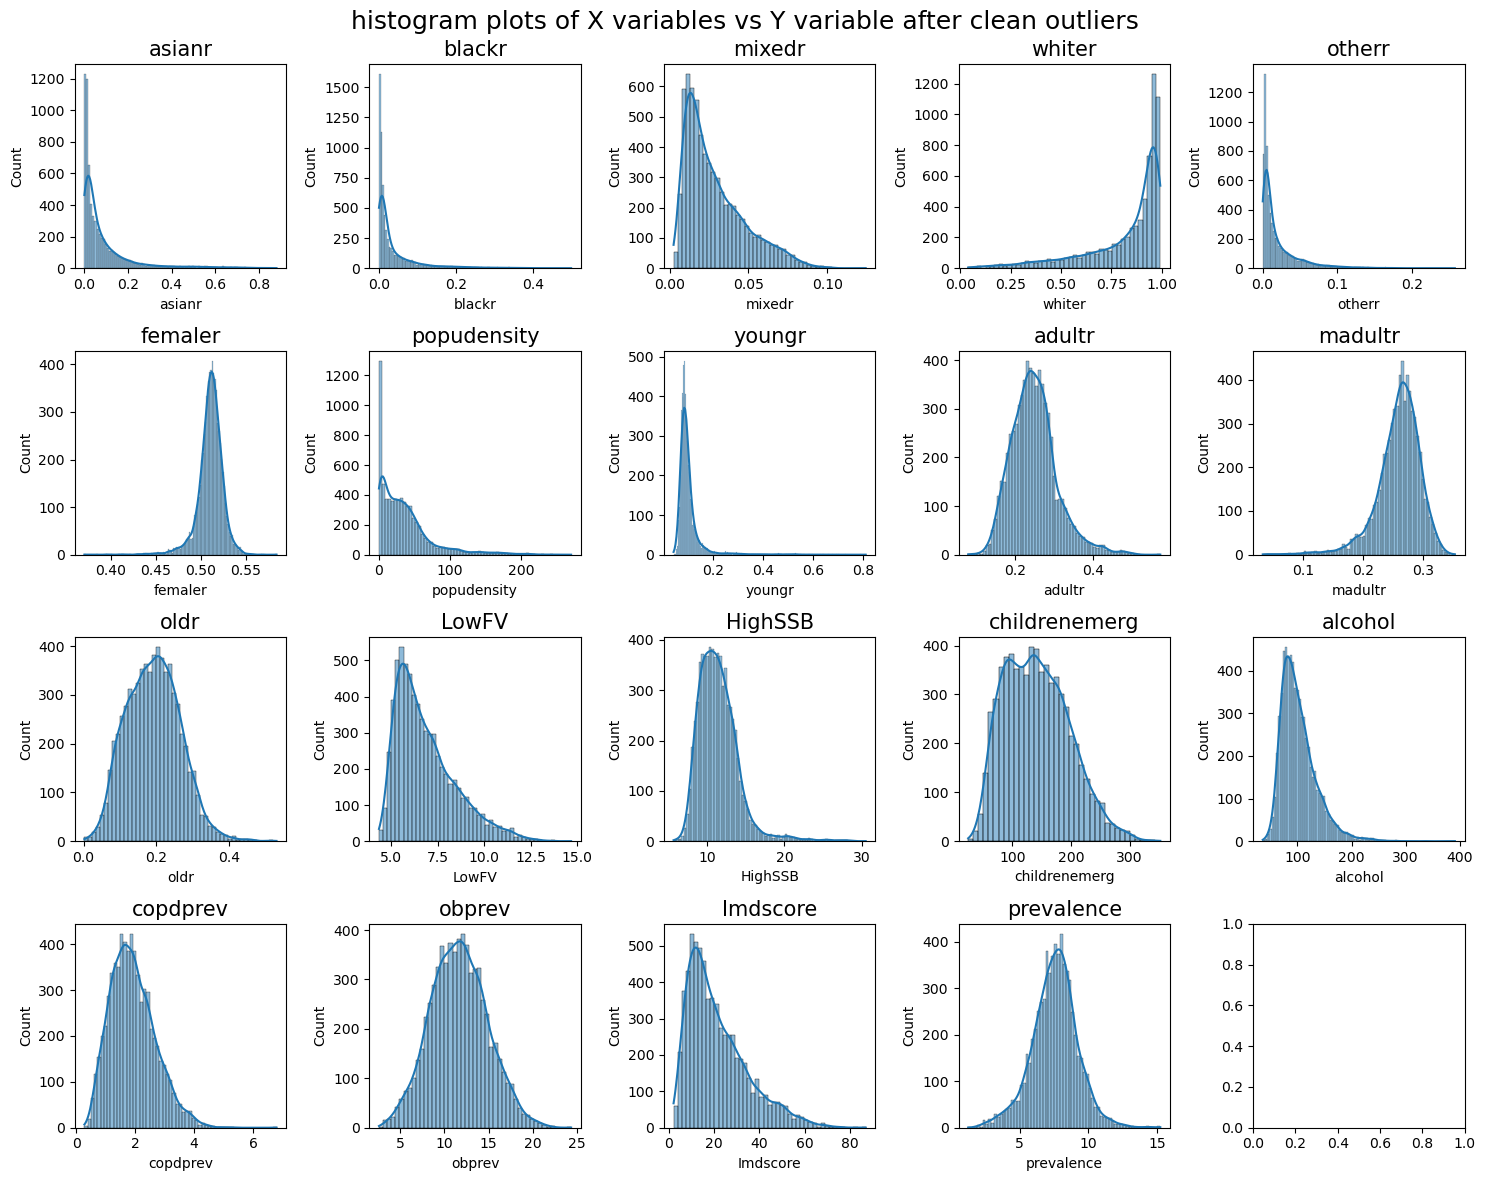

CPU times: user 16.3 s, sys: 135 ms, total: 16.4 s
Wall time: 3.18 s


In [143]:
%%time
make_hist(Vardata[Var_col].iloc[:, 1:])

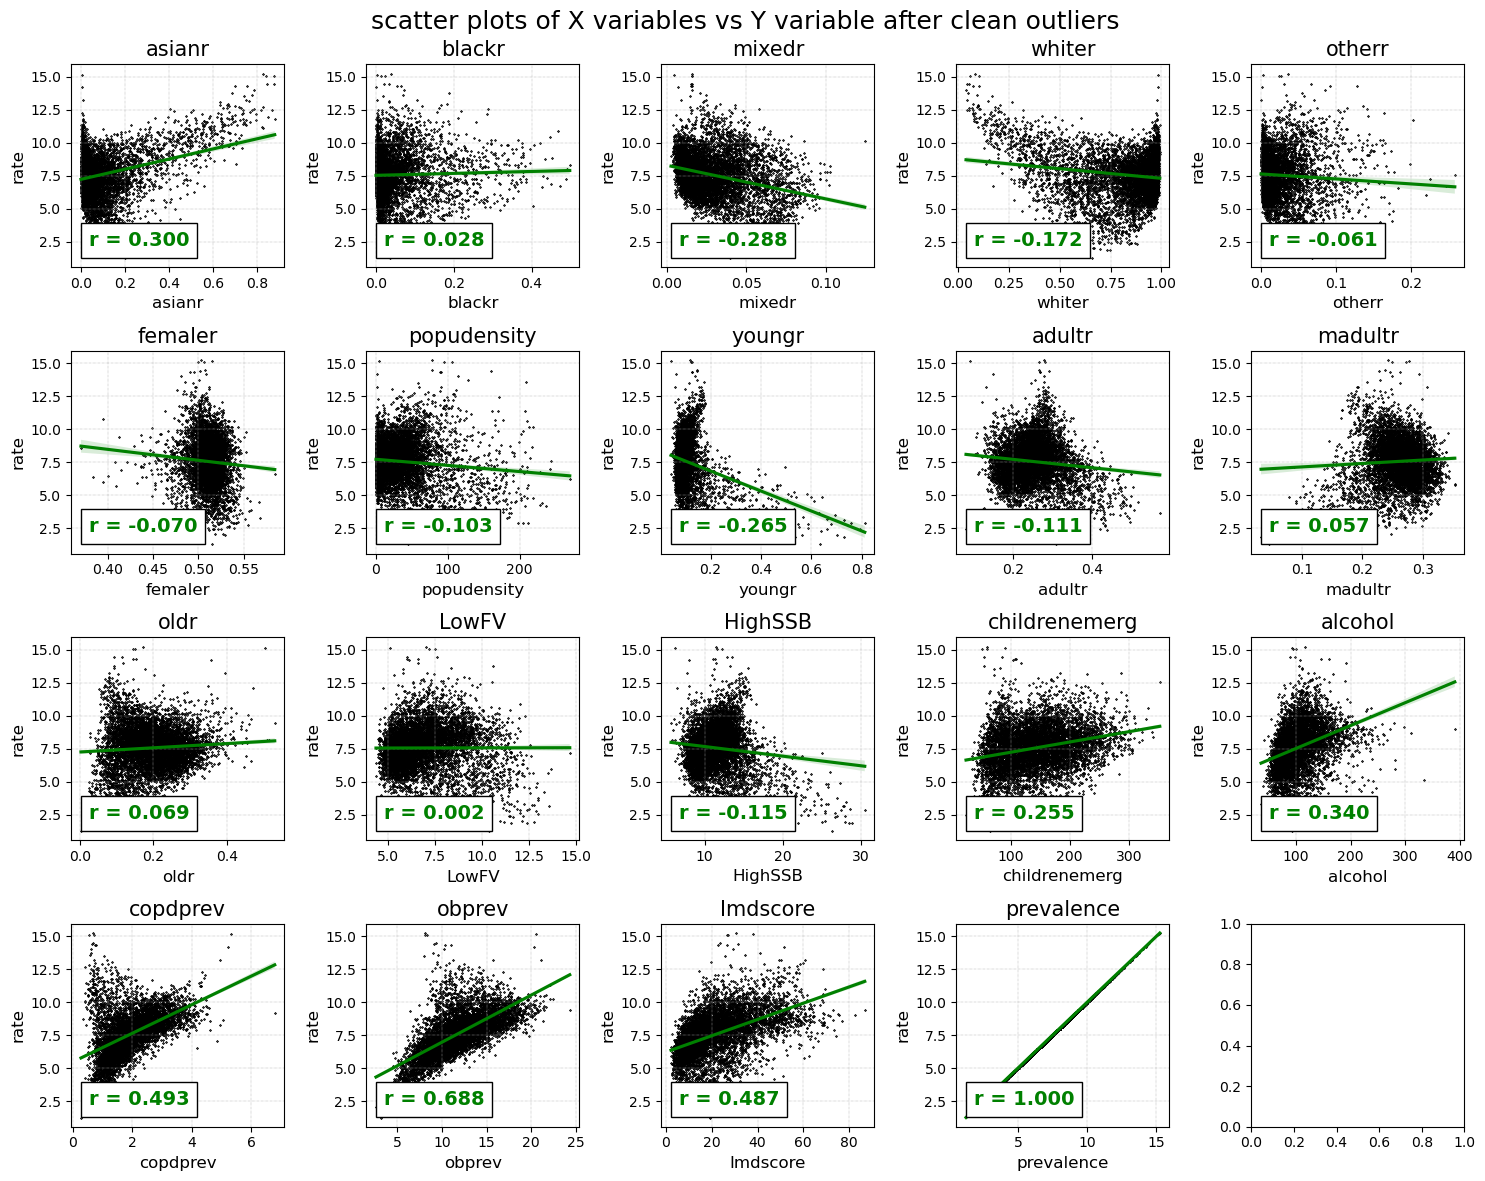

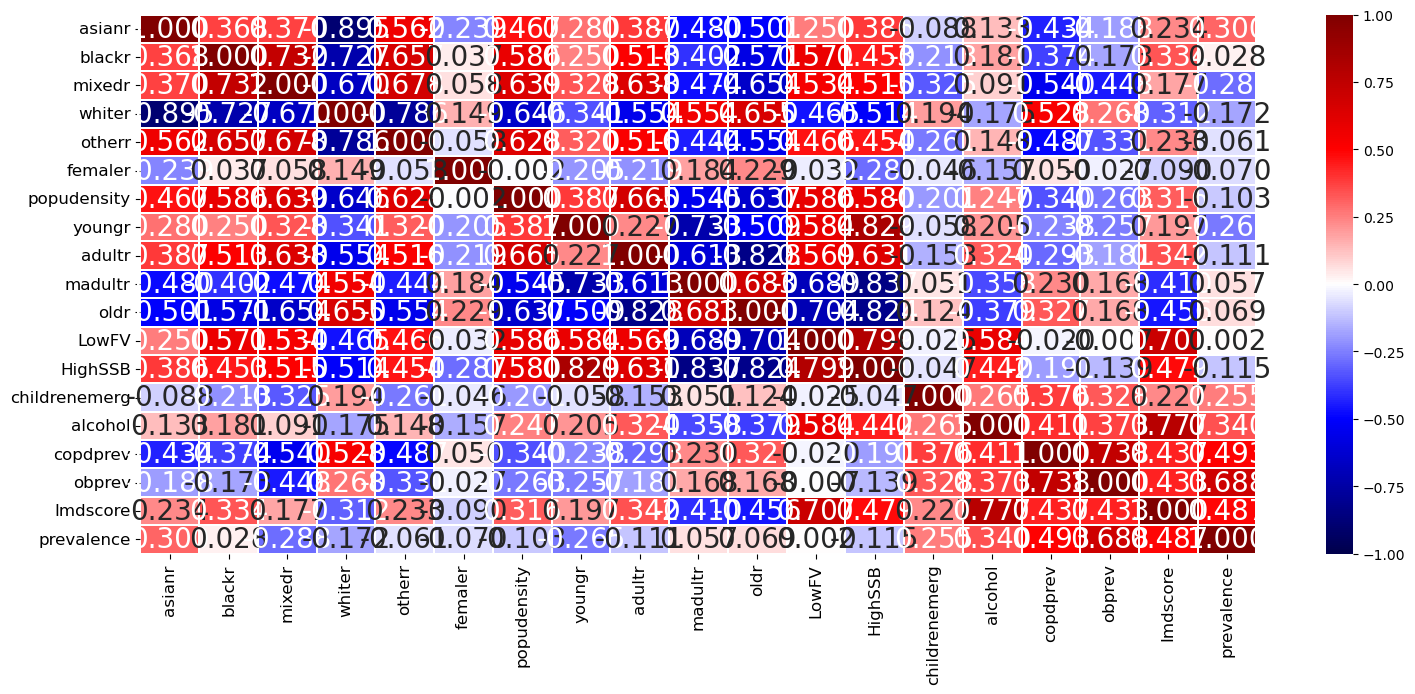

CPU times: user 29.4 s, sys: 785 ms, total: 30.2 s
Wall time: 29.2 s


In [144]:
%%time
make_correlation(Vardata[Var_col].iloc[:, 1:])

In [25]:
VardataT = Vardata.copy()

In [26]:
### VardataT['asianr'] = np.log(VardataT['asianr'])
# VardataT['blackr'] = np.log(VardataT['blackr'])
VardataT['mixedr'] = np.log(VardataT['mixedr'])
VardataT['popudensity'] = np.log(VardataT['popudensity'])
## VardataT['youngr'] = np.log(VardataT['youngr'])
VardataT['LowFV'] = np.log(VardataT['LowFV'])
VardataT['HighSSB'] = np.log(VardataT['HighSSB'])
VardataT['childrenemerg'] = np.log(VardataT['childrenemerg'])
VardataT['alcohol'] = np.log(VardataT['alcohol'])
VardataT['Imdscore'] = np.log(VardataT['Imdscore'])

# OLS

In [29]:
# Varols = Vardata.copy()
Varols = VardataT.copy()

In [30]:
Ycol = ['prevalence']
IDcol = ['MSOA11CD']

# correlation
Xvar = ['asianr',
#  'blackr',
 'mixedr',
#  'whiter',
#  'otherr',
#  'femaler',
#  'popudensity',
 'youngr',
#  'adultr',
#  'madultr',
#  'oldr',
#  'LowFV',
#  'HighSSB',
 'childrenemerg',
 'alcohol',
 'copdprev',
 'obprev',
#  'Imdscore',
#  'Imddecile',
 'Imdquintile']

In [39]:
# VIF data with imdquintile
VIFdata = Varols[Xvar]

VIFdata = VIFdata.dropna()

VIFdata = drop_column_using_vif_(VIFdata, thresh=3)

Max VIF: 4.078260312038506
Dropping: copdprev
Max VIF: 2.6164264482578816


In [40]:
VIFcol = ['MSOA11CD'] + list(VIFdata.columns) + ['prevalence']

# stepwise
VIFcol.remove("alcohol")
VIFcol.remove("childrenemerg")

In [41]:
make_ols(Varols[VIFcol].iloc[:, 1:])

                            OLS Regression Results                            
Dep. Variable:             prevalence   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     4045.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        10:34:23   Log-Likelihood:                -4945.4
No. Observations:                6791   AIC:                             9903.
Df Residuals:                    6785   BIC:                             9944.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -9.107e-17      0.006   -1.5e-14      

# Spatial Regression

## Spatial weighted matrix and coordinates

In [42]:
w_knn = libpysal.weights.KNN.from_dataframe(msoa_england_shp, k=10)

In [43]:
msoa_england_shp['centroid'] = msoa_england_shp.geometry.centroid

msoa_england_shp['BNG_E'] = msoa_england_shp.geometry.centroid.x
msoa_england_shp['BNG_N'] = msoa_england_shp.geometry.centroid.y

/Users/shengaric/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/shengaric/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/shengaric/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [44]:
Varsr = Varols[VIFcol].copy()

In [46]:
Varsr = pd.merge(Varsr, msoa_england_shp[['msoa11cd', 'BNG_E', 'BNG_N']], how='left',
                      left_on = 'MSOA11CD', right_on='msoa11cd')
Varsr = Varsr.dropna()
Varsr

,MSOA11CD,asianr,mixedr,youngr,obprev,Imdquintile,prevalence,msoa11cd,BNG_E,BNG_N
0,E02000001,0.168336,-2.904923,0.176731,3.35,4,2.74,E02000001,532484.503128,181269.534703
1,E02000002,0.222531,-3.010573,0.107705,12.49,1,9.58,E02000002,548314.767317,189881.619892
2,E02000003,0.349454,-3.171316,0.113700,12.29,2,9.61,E02000003,548456.778206,188400.365619
3,E02000004,0.158537,-3.295837,0.107424,14.72,2,8.98,E02000004,551010.883398,186311.177696
4,E02000005,0.300785,-3.145471,0.109361,13.48,2,9.26,E02000005,548668.962136,186903.545893
...,...,...,...,...,...,...,...,...,...,...
6786,E02004879,0.022318,-4.005438,0.081766,9.19,4,6.12,E02004879,532054.563735,225003.082293
6787,E02004938,0.068933,-3.108263,0.096748,8.85,4,5.46,E02004938,519209.943244,206708.226279
6788,E02004947,0.054365,-3.651979,0.084788,9.63,5,6.98,E02004947,526343.820861,225336.659753
6789,E02004993,0.066694,-3.124478,0.113730,8.14,4,5.05,E02004993,522779.376943,204750.611184


In [47]:
Varsr.iloc[:, 1:7]

,asianr,mixedr,youngr,obprev,Imdquintile,prevalence
0,0.168336,-2.904923,0.176731,3.35,4,2.74
1,0.222531,-3.010573,0.107705,12.49,1,9.58
2,0.349454,-3.171316,0.113700,12.29,2,9.61
3,0.158537,-3.295837,0.107424,14.72,2,8.98
4,0.300785,-3.145471,0.109361,13.48,2,9.26
...,...,...,...,...,...,...
6786,0.022318,-4.005438,0.081766,9.19,4,6.12
6787,0.068933,-3.108263,0.096748,8.85,4,5.46
6788,0.054365,-3.651979,0.084788,9.63,5,6.98
6789,0.066694,-3.124478,0.113730,8.14,4,5.05


In [49]:
# standardize the data and make to np array
Xt = scale_df(Varsr.iloc[:, 1:6]).values
Yt = scale_df(Varsr.iloc[:, 1:7])['prevalence'].values.reshape((-1,1))


# coordinates
coor_x = Varsr['BNG_E'].astype(float)
coor_y = Varsr['BNG_N'].astype(float)
coordinates = list(zip(coor_x, coor_y))

In [50]:
olsk = spreg.OLS(Yt, Xt, w_knn,
                 spat_diag=True,
                 moran=True)

print(olsk.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        6791
Mean dependent var  :     -0.0000                Number of Variables   :           6
S.D. dependent var  :      1.0001                Degrees of Freedom    :        6785
R-squared           :      0.7488
Adjusted R-squared  :      0.7486
Sum squared residual:     1706.05                F-statistic           :   4044.5769
Sigma-square        :       0.251                Prob(F-statistic)     :           0
S.E. of regression  :       0.501                Log likelihood        :   -4945.418
Sigma-square ML     :       0.251                Akaike info criterion :    9902.837
S.E of regression ML:      0.5012                Schwarz criterion     :    9943.777

------------------------------------------------------------

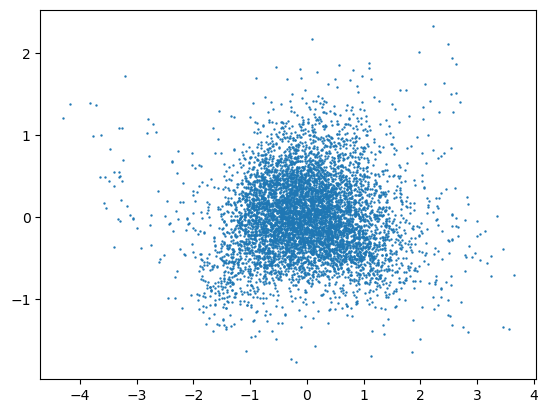

In [60]:
plt.scatter(olsk.predy, ols_resi, s=0.5)

<AxesSubplot:ylabel='Count'>

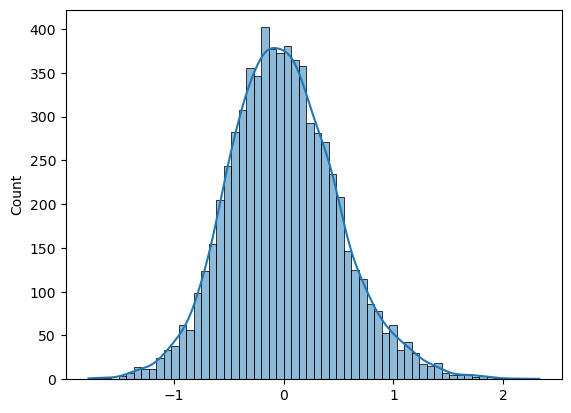

In [61]:
sns.histplot(ols_resi, kde=True)

In [51]:
moran_y = esda.moran.Moran(Yt, w_knn)
moran_residual = esda.moran.Moran(olsk.u, w_knn)

print(f"Moran's I y: {moran_y.I}")
print(f"p-value y: {moran_y.p_norm}")

print(f"Moran's I res: {moran_residual.I}")
print(f"p-value res: {moran_residual.p_norm}")

Moran's I y: 0.349229257658467
p-value y: 0.0
Moran's I res: 0.2658377563130212
p-value res: 0.0


In [53]:
%%time
lagt = spreg.ML_Lag(Yt, Xt, w=w_knn)

CPU times: user 4min 37s, sys: 18.8 s, total: 4min 56s
Wall time: 36.1 s


In [54]:
%%time
errt = spreg.ML_Error(Yt, Xt, w=w_knn)

/Users/shengaric/opt/anaconda3/lib/python3.9/site-packages/spreg/ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


CPU times: user 5min 29s, sys: 22.2 s, total: 5min 51s
Wall time: 43.9 s


In [55]:
print(lagt.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        6791
Mean dependent var  :     -0.0000                Number of Variables   :           7
S.D. dependent var  :      1.0001                Degrees of Freedom    :        6784
Pseudo R-squared    :      0.7697
Spatial Pseudo R-squared:  0.7380
Log likelihood      :  -4669.3380
Sigma-square ML     :      0.2303                Akaike info criterion :    9352.676
S.E of regression   :      0.4799                Schwarz criterion     :    9400.439

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

In [56]:
print(errt.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        6791
Mean dependent var  :     -0.0000                Number of Variables   :           6
S.D. dependent var  :      1.0001                Degrees of Freedom    :        6785
Pseudo R-squared    :      0.7481
Log likelihood      :  -4270.5613
Sigma-square ML     :      0.1967                Akaike info criterion :    8553.123
S.E of regression   :      0.4435                Schwarz criterion     :    8594.063

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.00257    

In [57]:
lagt_resi = (Yt - lagt.predy).flatten()
lagt_resi_moran = esda.moran.Moran(lagt_resi, w_knn)
print(lagt_resi_moran.I)
print(lagt_resi_moran.p_sim)
print(MSE(Yt, lagt.predy))

0.1598078895832383
0.001
0.2302607406718825


In [58]:
errt_resi = (Yt - errt.predy).flatten()
errt_resi_moran = esda.moran.Moran(errt.u, w_knn)
print(errt_resi_moran.I)
print(errt_resi_moran.p_sim)
print(MSE(Yt, errt.predy))

0.2716725532473854
0.001
0.25208755364852325


In [59]:
ols_resi = (Yt - olsk.predy).flatten()
ols_resi_moran = esda.moran.Moran(ols_resi, w_knn)
print(ols_resi_moran.I)
print(ols_resi_moran.p_sim)
print(MSE(Yt, olsk.predy))

0.2658377563130212
0.001
0.2512229327417864


# GWR

In [62]:
%%time
bandwidth = mgwr.sel_bw.Sel_BW(coordinates, Yt, Xt).search()
print(bandwidth)

53.0
CPU times: user 6.31 s, sys: 1.5 s, total: 7.81 s
Wall time: 14.5 s


In [63]:
%%time
GWRt = GWR(coordinates, Yt, Xt, bandwidth).fit()

CPU times: user 472 ms, sys: 77 ms, total: 549 ms
Wall time: 834 ms


In [64]:
GWRt.summary()

Model type                                                         Gaussian
Number of observations:                                                6791
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1706.055
Log-likelihood:                                                   -4945.418
AIC:                                                               9902.837
AICc:                                                              9904.853
BIC:                                                             -58160.398
R2:                                                                   0.749
Adj. R2:                                                              0.749

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [67]:
var_name_x_t = VIFcol[1:-1]

# significant filter
filter_t = GWRt.filter_tvals(alpha=0.05)

# make the dataframe
coefficient_t = pd.DataFrame(filter_t)
coefficient_t.columns = ['intercept'] + var_name_x_t

residual_t = pd.DataFrame(GWRt.resid_response)
residual_t.columns = ['residual']

id_t = pd.DataFrame(Varsr["MSOA11CD"])

# concat the dataframe
gwrdata = pd.concat([id_t, coefficient_t, residual_t], axis=1)

# merge with lsoa shapefile
gwrdata = pd.merge(msoa_england_shp, gwrdata, how='left',
                       left_on='msoa11cd', right_on='MSOA11CD')

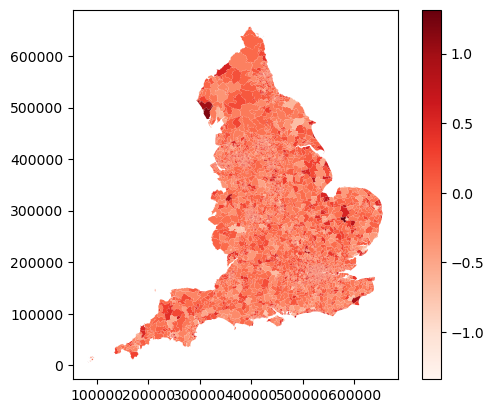

In [68]:
# Residual plot
gwrdata.plot('residual',
                 vmin=np.min(gwrdata.residual),
                 vmax=np.max(gwrdata.residual),
                 legend=True,
                 cmap='Reds')
plt.show()

In [69]:
print(esda.moran.Moran(gwrdata.residual, w_knn).I)
print(esda.moran.Moran(gwrdata.residual, w_knn).p_sim)
print(MSE(Yt, GWRt.predy))

0.04853548740857041
0.001
0.054128562708159855


In [70]:
def gwr_mask(gwrdata, var):
    # adding significant mask
    mask = gwrdata[var] == 0

    gwrdata['var_masked'] = np.where(mask, np.nan, gwrdata[var])
    
    
    # plotting the IMD decile coefficient plot
    from matplotlib.colors import TwoSlopeNorm
    vmin = np.min(gwrdata['var_masked'].dropna())
    vmax = np.max(gwrdata['var_masked'].dropna())

    max_abs = max(abs(vmin), abs(vmax))

    norm = TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)


    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.set_title('GWR var coefficients within significant', fontsize=12)


    gwrdata.plot('var_masked', ax=ax,
                 legend=True,
                 cmap='bwr',
                 norm=norm)

    gwrdata[mask].plot(ax=ax, color='grey', legend=True)

    plt.show()

# MGWR

In [73]:
bandwidth_sel_MGWR = mgwr.sel_bw.Sel_BW(coordinates, Yt, Xt, multi=True)

In [74]:
%%time
bandwidth_MGWR = bandwidth_sel_MGWR.search()
print(bandwidth_MGWR)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

/Users/shengaric/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[ 43.  43.  43. 203.  43. 110.]
CPU times: user 16min 23s, sys: 1min 56s, total: 18min 20s
Wall time: 55min 37s


In [75]:
%%time
MGWRt = MGWR(coordinates, Yt, Xt, bandwidth_sel_MGWR).fit()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 5h 8min 13s, sys: 28min 30s, total: 5h 36min 44s
Wall time: 10h 12min 36s


In [76]:
MGWRt.summary()

Model type                                                         Gaussian
Number of observations:                                                6791
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1706.055
Log-likelihood:                                                   -4945.418
AIC:                                                               9902.837
AICc:                                                              9904.853
BIC:                                                             -58160.398
R2:                                                                   0.749
Adj. R2:                                                              0.749

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [78]:
var_name_x_t = VIFcol[1:-1]

# significant filter
Mfilter_t = MGWRt.filter_tvals(alpha=0.05)

# make the dataframe
Mcoefficient_t = pd.DataFrame(Mfilter_t)
Mcoefficient_t.columns = ['intercept'] + var_name_x_t

Mresidual_t = pd.DataFrame(MGWRt.resid_response)
Mresidual_t.columns = ['residual']

id_t = pd.DataFrame(Varsr["MSOA11CD"])

# concat the dataframe
Mgwrdata = pd.concat([id_t, Mcoefficient_t, Mresidual_t], axis=1)

# merge with lsoa shapefile
Mgwrdata = pd.merge(msoa_england_shp, Mgwrdata, how='left',
                       left_on='msoa11cd', right_on='MSOA11CD')

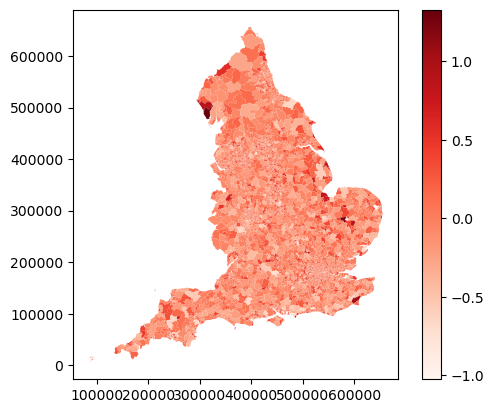

In [79]:
# Residual plot
Mgwrdata.plot('residual',
                 vmin=np.min(Mgwrdata.residual),
                 vmax=np.max(Mgwrdata.residual),
                 legend=True,
                 cmap='Reds')
plt.show()

In [85]:
Mgwr_resi = Mgwrdata.residual
Mgwr_resi_moran = esda.moran.Moran(Mgwr_resi, w_knn)
print(Mgwr_resi_moran.I)
print(Mgwr_resi_moran.p_sim)
# print(np.sqrt(gwr_resi).sum())
print(Mgwr_resi_moran.p_norm)
print(Mgwr_resi_moran.p_rand)

-0.00914504117638572
0.046
0.07842773966422541
0.07839874246494652


In [90]:
# Mgwrdata_save = Mgwrdata
# Mgwrdata_save.to_csv("/Users/shengaric/Desktop/CASA0010 Dissertation/main_code/savedata/Mgwrdata_save.csv", index=False)

In [118]:
MgwrdataA_url = "https://github.com/ShengAric92/CASA0010_dissertation/raw/main/main_code/savedata/Mgwrdata_save.csv"
MgwrdataA = pd.read_csv(MgwrdataA_url)

In [119]:
MgwrdataA_plot = pd.merge(msoa_england_shp, MgwrdataA.iloc[:, 10:], how='left',
                     left_on='msoa11cd', right_on='MSOA11CD')

In [120]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm

def gwr_mask(gwrdata, var, ax):
    # adding significant mask
    mask = gwrdata[var] == 0

    gwrdata['var_masked'] = np.where(mask, np.nan, gwrdata[var])
    
    # plotting the IMD decile coefficient plot
    vmin = np.min(gwrdata['var_masked'].dropna())
    vmax = np.max(gwrdata['var_masked'].dropna())

    max_abs = max(abs(vmin), abs(vmax))

    norm = TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)

    # Plotting on the provided axis
    gwrdata.plot('var_masked', ax=ax,
                 legend=True,
                 cmap='bwr',
                 norm=norm)

    gwrdata[mask].plot(ax=ax, color='grey', legend=True)
    ax.set_title(f'GWR {var} coefficients', fontsize=12)

def plot_maps(gwrdata, variables):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 

    for i, var in enumerate(variables):
        row = i // 3
        col = i % 3
        gwr_mask(gwrdata, var, axes[row, col])

    plt.tight_layout()
    plt.show()

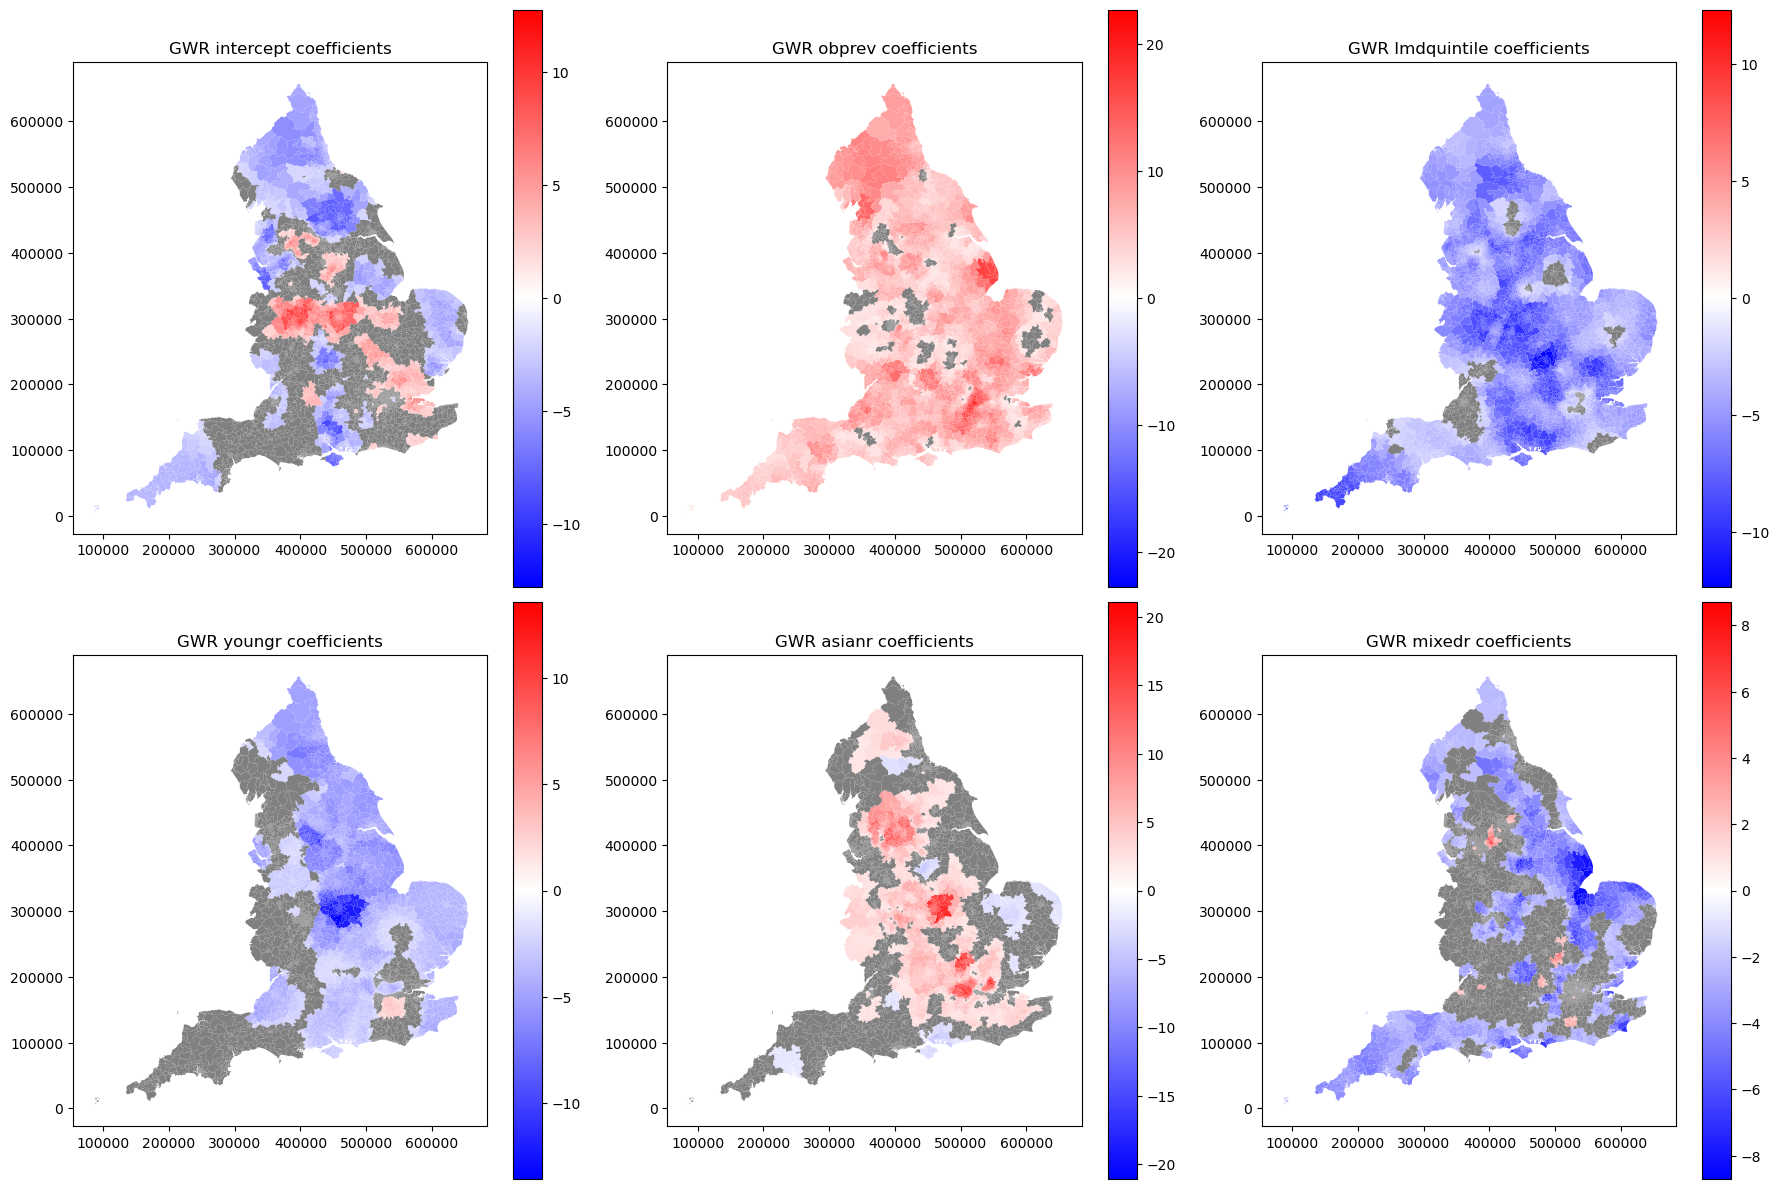

In [121]:
Var_name = ['intercept', 'obprev', 'Imdquintile', 'youngr', 'asianr', 'mixedr']
plot_maps(MgwrdataA_plot, Var_name)